In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import datetime
import plotly.express as px

In [2]:
df=pd.read_csv('cleaned data.zip', compression='zip',low_memory=False)

--------

###Task 2: We would like to perform an analysis in the top 10 airports in terms of departure delay. 

Create a metric to rank each airport according to the average number of aircraft that departed from that airport having a DEPARTURE_DELAY > 15 mins. 

Please describe if such a metric would be efficient to compare airports and include any suggestion to improve such a comparison.

In [3]:
df['DELAY15']=0
df.loc[(df['DEPARTURE_DELAY']>15),'DELAY15']=1

In [4]:
aggregated=df[['ORIGIN_AIRPORT','DELAY15','ORIG_AIRPORT']].groupby(['ORIGIN_AIRPORT','ORIG_AIRPORT'])['DELAY15']\
    .sum().reset_index(name='count_delayed').sort_values(['count_delayed'], ascending=False)

#Ranking Airports in terms of absolute numbers of delayed flights, would be biased torwards the most busy airports

In [5]:
aggregated.head(10)

,ORIGIN_AIRPORT,ORIG_AIRPORT,count_delayed
228,ORD,Chicago O'Hare International Airport,65125
20,ATL,Hartsfield-Jackson Atlanta International Airport,58902
86,DFW,Dallas/Fort Worth International Airport,49384
85,DEN,Denver International Airport,42432
176,LAX,Los Angeles International Airport,39099
151,IAH,George Bush Intercontinental Airport,29472
278,SFO,San Francisco International Airport,29322
174,LAS,McCarran International Airport,27453
239,PHX,Phoenix Sky Harbor International Airport,26186
106,EWR,Newark Liberty International Airport,22605


In [6]:
a=df[['ORIGIN_AIRPORT','DELAY15']].groupby(['ORIGIN_AIRPORT'])['ORIGIN_AIRPORT'].count().reset_index(name='total_flights')
b=df[['ORIGIN_AIRPORT','DELAY15']].groupby(['ORIGIN_AIRPORT'])['DELAY15'].mean().reset_index(name='delayed_flights_15m%')
aggregated=aggregated.merge(a,on='ORIGIN_AIRPORT')
aggregated=aggregated.merge(b,on='ORIGIN_AIRPORT')

#On the other hand ranking in terms of averaged delayed flights, is biased towards small airports:

     -do not have large volume of flights
     -secondary role in the air transport industry (i.e. funds,processes etc). 

It would be usefull to identify those airports, but should these be addressed and fixed, it would still not create a large impresion in the overal delays in the industry.

In [7]:
aggregated.sort_values(['delayed_flights_15m%'], ascending=False).head(10)

,ORIGIN_AIRPORT,ORIG_AIRPORT,count_delayed,total_flights,delayed_flights_15m%
303,ADK,Adak Airport,36,88,0.409091
310,GST,Gustavus Airport,29,76,0.381579
305,ILG,Wilmington Airport,35,95,0.368421
312,STC,St. Cloud Regional Airport,24,77,0.311688
285,MVY,Martha's Vineyard Airport,63,205,0.307317
300,UST,Northeast Florida Regional Airport (St. August...,44,144,0.305556
275,OTH,Southwest Oregon Regional Airport (North Bend ...,74,264,0.280303
293,CEC,Del Norte County Airport (Jack McNamara Field),48,173,0.277457
271,PBG,Plattsburgh International Airport,76,278,0.273381
103,ASE,Aspen-Pitkin County Airport,882,3263,0.270303


#We will use the median of 'departure delay' when there is an actual delay (since the variable also has negative values when airplane departed earlier than scheduled). This will inform us as to the typical delay and allow us to evaluate the low performing airports.

In [8]:
c=df[df['DEPARTURE_DELAY']>0].groupby(['ORIGIN_AIRPORT'])['DEPARTURE_DELAY'].median().reset_index(name='median_actual_delay')
aggregated=aggregated.merge(c,on='ORIGIN_AIRPORT').sort_values(['median_actual_delay','delayed_flights_15m%'], ascending=False)


Having evaluated the Top 10 airports in terms of the median we are again met with very small airports. But without understanding if this occurs due to their performance or external reasons. 

We could control for the number of flights, and choose only airports with at least 10 per day, then examine the median. This will not be further explored at this time.

In [9]:
aggregated.sort_values(['median_actual_delay','delayed_flights_15m%'], ascending=False).head(10)

,ORIGIN_AIRPORT,ORIG_AIRPORT,count_delayed,total_flights,delayed_flights_15m%,median_actual_delay
312,STC,St. Cloud Regional Airport,24,77,0.311688,52.0
265,PLN,Pellston Regional Airport of Emmet County,85,730,0.116438,48.0
293,CEC,Del Norte County Airport (Jack McNamara Field),48,173,0.277457,38.5
281,APN,Alpena County Regional Airport,69,546,0.126374,38.0
289,ESC,Delta County Airport,53,554,0.095668,37.0
301,MMH,Mammoth Yosemite Airport,37,140,0.264286,36.0
175,ACV,Arcata Airport,280,1268,0.220820,36.0
287,INL,Falls International Airport,53,556,0.095324,34.0
275,OTH,Southwest Oregon Regional Airport (North Bend ...,74,264,0.280303,31.0
302,PUB,Pueblo Memorial Airport,36,253,0.142292,31.0


We in turn test the performance of the airports in terms of taxi out: 

       "departure runway queuing time on the outbound traffic flow, during congestion periods at airports, is mainly a factor of the airport delays"

    Measure: a single value at airport level, i.e. the 25th percentile of actual taxi times recorded at an airport, sorted from the shortest to the longest.
    REF: https://www.icao.int/SAM/Documents/2020-RLA06901-ANPVOLIII/KPI%201%20al%2019%20%20detailed.pdf

In [10]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

e=df[df['DEPARTURE_DELAY']>0].groupby(['ORIGIN_AIRPORT'])['TAXI_OUT'].agg([percentile(25), percentile(50)]).reset_index()
aggregated=aggregated.merge(e,on='ORIGIN_AIRPORT')

In [11]:
aggregated.sort_values(['percentile_25'], ascending=False).head(10)

,ORIGIN_AIRPORT,ORIG_AIRPORT,count_delayed,total_flights,delayed_flights_15m%,median_actual_delay,percentile_25,percentile_50
155,JFK,John F. Kennedy International Airport (New Yor...,18448,91663,0.201259,17.0,19.0,25.0
86,LGA,LaGuardia Airport (Marine Air Terminal),20804,94834,0.219373,20.0,17.0,24.0
98,CIU,Chippewa County International Airport,85,596,0.142617,20.0,15.0,18.0
189,EWR,Newark Liberty International Airport,22605,98341,0.229863,16.0,14.0,18.0
153,MIA,Miami International Airport,15364,68301,0.224945,17.0,14.0,17.0
76,COS,City of Colorado Springs Municipal Airport,990,6745,0.146775,21.0,14.0,16.0
251,BOS,Gen. Edward Lawrence Logan International Airport,18632,104804,0.177779,14.0,14.0,18.0
274,CLT,Charlotte Douglas International Airport,16410,99052,0.165671,13.0,14.0,18.0
217,PHL,Philadelphia International Airport,11895,64751,0.183704,15.0,14.0,19.0
129,ORD,Chicago O'Hare International Airport,65125,276554,0.235487,18.0,14.0,18.0


Evaluating airports as to the 25th percentile of taxi out time, provides a more accurate picture. We can get a picture of inefficiencies in large airports with heavy traffic.

In [12]:
#We create a list with these TOP10 airports
top_ten=aggregated.sort_values(['percentile_25'], ascending=False).head(10)['ORIGIN_AIRPORT'].to_list()

In [13]:

temp=df[df['ORIGIN_AIRPORT'].isin(top_ten)]

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
#Striplot with plotly crashes for such a large dataset

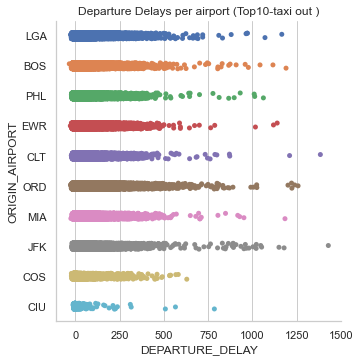

In [15]:
sns.set(style = 'whitegrid')
sns.catplot(data=temp, x="DEPARTURE_DELAY", y="ORIGIN_AIRPORT").set(title='Departure Delays per airport (Top10-taxi out )')

-----------------

Task 3: We would like to find the association, if any, between these top 10 airports and the aircraft that had no previous arrival delay (ARRIVAL_DELAY < 15) on a given day but they had arrival delay > 15 mins as soon as they departed from these airports. Please create any metrics and plots and use any technique you deem necessary to indicate the potential existence of such a phenomenon.

------------------------------------



We would first clarify if the flights are concecutive. For example it would not make sence to examine the effects of the arrival delay for a flights that arrived noon the previous day but departed morning the next. Any consecutive delay would not be the result of the initial delay, considering the airplane can adjust speed.

The issue is that we do not have available the time needed for turnaround. In some cases, aircrafts refuel and in some other they make stops without refuelling, thus affecting turnaround time. 

We will thus simplify the procedure by controling for the time between arrival of previous flight and departure of the next:

    -IF an airplane more than 2 hours betweem actual arrival and next schedulled departure, any previous arrival delay will be considered 0.

    -Otherwise previews arrival delay will be used to examine the relationship with consecutive arrival delay

This was already done during the cleaning and transforming

In [16]:
temp['pre_arrival_15m']=0
temp.loc[(temp['previous_arrival_delay']>15),'pre_arrival_15m']=1
temp['arrival_15']=0
temp.loc[(temp['ARRIVAL_DELAY']>15),'arrival_15']=1

C:\Users\c.logaras\Anaconda3\envs\p37env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\c.logaras\Anaconda3\envs\p37env\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\c.logaras\Anaconda3\envs\p37env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

#We will drop each first occurance for each plane - that is why we chose not to fillna

In [17]:
temp['num_in_group'] = temp.groupby('TAIL_NUMBER').cumcount()

temp.drop(temp.loc[temp['num_in_group']==0].index, inplace=True)

C:\Users\c.logaras\Anaconda3\envs\p37env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\c.logaras\Anaconda3\envs\p37env\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [18]:
corr=temp['pre_arrival_15m'].corr(temp['arrival_15'])

In [19]:
print('We first check if there is correlation between resulting arrival delay over 15m, due to the initial arrival delay over 15m.\
The correlation is :'+str(corr))

We first check if there is correlation between resulting arrival delay over 15m, due to the initial arrival delay over 15m.The correlation is :0.39905871320858943


In [23]:
corr=temp['previous_arrival_delay'].corr(temp['ARRIVAL_DELAY'])
print('If we also check the parameter of arrival delay wihout the 15m criterion, the \
correlation is :'+str(corr))

If we also check the parameter of arrival delay wihout the 15m criterion, the correlation is :0.46315350349231393


There does not seem to be a strong correlation. Next we will plot the previous and consecutive arrival delay for each of our aiports.

In [34]:
def show_relation(temp,airport):
    '''It creates a scatterpolot for previous arrival delay and concecutive arrival delay
    Required statsmodels to be installed'''
    fig = px.scatter(temp[temp["ORIGIN_AIRPORT"]==airport], x="previous_arrival_delay", y="ARRIVAL_DELAY",\
                     color="DEPARTURE_DELAY",trendline="ols",title='Consecutive and previous arrival delay scatterplot for '+airport)
    fig.show()

In [47]:
# Please choose the airport to graph relationship :'LGA', 'BOS', 'PHL', 'EWR', 'CLT', 'ORD', 'MIA', 'JFK', 'COS','CIU'
show_relation(temp,'CIU')

In [48]:
#Checking the extreme values
temp[(temp["ORIGIN_AIRPORT"]=='JFK')&(temp["previous_arrival_delay"]==1010)]

,Unnamed: 0,DATE,DAY_OF_WEEK,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,previous_arrival_time,previous_arrival_delay,SCHEDULED_DEPARTURE_DT,arr_depart_diff,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ACTUAL_ARRIVAL_TIME,ARRIVAL_DELAY,AIRLINE,ORIG_AIRPORT,DEST_AIRPORT,delay,Div/Canc,arr_depart_diff.1,DELAY15,pre_arrival_15m,arrival_15,num_in_group
1347757,503807,2015-02-03,2,404,N392DA,JFK,LAS,2015-02-03 09:06:00,1010.0,2015-02-03 09:59:00,53.0,10:12:00,13.0,18.0,10:30:00,361.0,353.0,330.0,2248,1300.0,5.0,13:00:00,2015-02-03 13:05:00,5.0,Delta Air Lines Inc.,John F. Kennedy International Airport (New Yor...,McCarran International Airport,1,0,53.0,0,1,0,17


In [49]:
#Checking the extreme values
df[(df["DATE"].isin(['2015-02-02','2015-02-03','2015-02-04']))&(df["TAIL_NUMBER"]=='N392DA') ]

,Unnamed: 0,DATE,DAY_OF_WEEK,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,previous_arrival_time,previous_arrival_delay,SCHEDULED_DEPARTURE_DT,arr_depart_diff,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ACTUAL_ARRIVAL_TIME,ARRIVAL_DELAY,AIRLINE,ORIG_AIRPORT,DEST_AIRPORT,delay,Div/Canc,arr_depart_diff.1,DELAY15
1347755,487307,2015-02-02,1,2060,N392DA,JFK,FLL,2015-02-01 19:21:00,0.0,2015-02-02 09:15:00,834.0,12:14:00,179.0,59.0,13:13:00,205.0,227.0,162.0,1069,1555.0,6.0,12:40:00,2015-02-02 16:01:00,201.0,Delta Air Lines Inc.,John F. Kennedy International Airport (New Yor...,Fort Lauderdale-Hollywood International Airport,1,0,834.0,1
1347756,491428,2015-02-02,1,1508,N392DA,FLL,JFK,2015-02-02 16:01:00,201.0,2015-02-02 13:20:00,-161.0,06:25:00,1025.0,15.0,06:40:00,176.0,161.0,134.0,1069,854.0,12.0,16:16:00,2015-02-03 09:06:00,1010.0,Delta Air Lines Inc.,Fort Lauderdale-Hollywood International Airport,John F. Kennedy International Airport (New Yor...,1,0,-161.0,1
1347757,503807,2015-02-03,2,404,N392DA,JFK,LAS,2015-02-03 09:06:00,1010.0,2015-02-03 09:59:00,53.0,10:12:00,13.0,18.0,10:30:00,361.0,353.0,330.0,2248,1300.0,5.0,13:00:00,2015-02-03 13:05:00,5.0,Delta Air Lines Inc.,John F. Kennedy International Airport (New Yor...,McCarran International Airport,1,0,53.0,0
1347758,507562,2015-02-03,2,1740,N392DA,LAS,SLC,2015-02-03 13:05:00,5.0,2015-02-03 13:50:00,45.0,13:49:00,-1.0,15.0,14:04:00,80.0,75.0,57.0,368,1601.0,3.0,16:10:00,2015-02-03 16:04:00,-6.0,Delta Air Lines Inc.,McCarran International Airport,Salt Lake City International Airport,0,0,45.0,0
1347759,510605,2015-02-03,2,2360,N392DA,SLC,DCA,2015-02-03 16:04:00,-6.0,2015-02-03 17:02:00,58.0,16:56:00,-6.0,14.0,17:10:00,235.0,216.0,199.0,1851,2229.0,3.0,22:57:00,2015-02-03 22:32:00,-25.0,Delta Air Lines Inc.,Salt Lake City International Airport,Ronald Reagan Washington National Airport,0,0,58.0,0
1347760,515917,2015-02-04,3,872,N392DA,DCA,ATL,2015-02-03 22:32:00,0.0,2015-02-04 06:59:00,507.0,06:51:00,-8.0,22.0,07:13:00,129.0,112.0,82.0,547,835.0,8.0,09:08:00,2015-02-04 08:43:00,-25.0,Delta Air Lines Inc.,Ronald Reagan Washington National Airport,Hartsfield-Jackson Atlanta International Airport,0,0,507.0,0


In terms of cause and effect we expect
previous arrival ->  departure -> arrival

In [50]:
import statsmodels.api as sm

------------

In [54]:
#First we will do a regression analysis on previous arrival delay and concecutive arrival delay
x = temp[['previous_arrival_delay']]
y = temp['ARRIVAL_DELAY']
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
predictions = model.predict(x) 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:          ARRIVAL_DELAY   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                 2.461e+05
Date:                Wed, 21 Sep 2022   Prob (F-statistic):               0.00
Time:                        12:36:23   Log-Likelihood:            -4.5568e+06
No. Observations:              901006   AIC:                         9.114e+06
Df Residuals:                  901004   BIC:                         9.114e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      4

While the null hypothesis is rejected and appears to be statistical relationship between previous and concecutive delay, the R2 , that is the proportion of the variation in concecutive_arrival that is predictable from the previous_arrival, is very small. We can then verify that there are multiple factors to be taken into consideration, such as adjustment of speed during flights, changing routes or refuelling plans that affect turnaround time.

--------------

In [62]:
x = temp[['DEPARTURE_DELAY']]
y = temp['ARRIVAL_DELAY']
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:          ARRIVAL_DELAY   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                 5.640e+06
Date:                Wed, 21 Sep 2022   Prob (F-statistic):               0.00
Time:                        13:14:46   Log-Likelihood:            -3.7725e+06
No. Observations:              901006   AIC:                         7.545e+06
Df Residuals:                  901004   BIC:                         7.545e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -6.2026      0.018   -3

Performing OLS with only departure delay as a dependent variable, the explained variability increases significantly.

---------------

In [63]:
X = temp[['pre_arrival_15m']]
y= temp[['arrival_15']]
X = sm.add_constant(X)
log_reg = sm.Logit(y, X).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.458562
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             arrival_15   No. Observations:               901006
Model:                          Logit   Df Residuals:                   901004
Method:                           MLE   Df Model:                            1
Date:                Wed, 21 Sep 2022   Pseudo R-squ.:                  0.1250
Time:                        13:16:43   Log-Likelihood:            -4.1317e+05
converged:                       True   LL-Null:                   -4.7221e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.7028      0.003   -544.290      0.000      -1.709      -1.697
pre_arrival_15

Categorizing delays over or under 15 minutes does not provide explainability based on Pseudo R-square. 

Departure delay does perform better though.

In [57]:
corr=temp['previous_arrival_delay'].corr(temp['DEPARTURE_DELAY'])

In [64]:
X = temp[['DELAY15']]
y= temp[['arrival_15']]
X = sm.add_constant(X)   
log_reg = sm.Logit(y, X).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.300938
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             arrival_15   No. Observations:               901006
Model:                          Logit   Df Residuals:                   901004
Method:                           MLE   Df Model:                            1
Date:                Wed, 21 Sep 2022   Pseudo R-squ.:                  0.4258
Time:                        13:22:04   Log-Likelihood:            -2.7115e+05
converged:                       True   LL-Null:                   -4.7221e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.6465      0.005   -555.185      0.000      -2.656      -2.637
DELAY15        3.9608      0.

---------------